In [1]:
!pip install pyspark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
!ls /usr/lib/jvm/

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext,SQLContext
#spark = SparkContext()

In [0]:
#sc.stop()

In [0]:
sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

## Mobilenet 

In [ ]:
in_bucket="s3://dsde6007.rahul/devicestatus.txt"

In [ ]:
devicestatus = sc.textFile(in_bucket)

In [ ]:
def clean_data(data):
  data = data.split("\n")
  data = re.sub("[\|/]", ",", data)
  data = data.split(",")
  data = (data[-1], data[-2], data[0], data[1])
  data[3] = data[3].split()

In [0]:
devicestatus = clean_data(devicestatus)

In [9]:
devicestatus.take(5)

[(33.6894754264, -117.543308253, '2014-03-15:10:10:20', 'Sorrento', 'F41L'),
 (37.4321088904, -121.485029632, '2014-03-15:10:10:20', 'MeeToo', '1.0'),
 (39.4378908349, -120.938978486, '2014-03-15:10:10:20', 'MeeToo', '1.0'),
 (39.3635186767, -119.400334708, '2014-03-15:10:10:20', 'Sorrento', 'F41L'),
 (33.1913581092, -116.448242643, '2014-03-15:10:10:20', 'Ronin', 'Novelty')]

In [0]:
from pyspark.sql import types
df = spark.createDataFrame(devicestatus, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longtitude', types.FloatType(),True),
                                                        types.StructField('datestr', types.StringType(),True),
                                                        types.StructField('manufacturer', types.StringType(),True),
                                                        types.StructField('model_name', types.StringType(),True)
]))

In [0]:
df['date'] = df['datestr'].astype('datetime64[ns]')

In [ ]:
df = df['latitude', 'longitude', 'date', 'manufacturer', 'model_name']

In [0]:
output_bucket="data"

In [0]:
df.rdd.coalesce(1).saveAsTextFile(output_bucket)

In [0]:
timetable=[]

In [0]:
data = sc.textFile("data")

In [16]:
print(data.take(1))

["Row(latitude=33.689476013183594, longtitude=-117.54330444335938, date='2014-03-15 10:10:20', manufacturer='Sorrento', model_name='F41L')"]


In [ ]:
import re
def clean(data):
    data = re.sub("[A-Za-z\(]+=", "", data)
    data = data.replace(')','')
    data = data.replace("'", "")
    data = data.split(", ")
    data[0], data[1] = float(data[0]), float(data[1])

In [ ]:
%time
data = clean(data)

In [18]:
data.cache()

PythonRDD[19] at RDD at PythonRDD.scala:53

In [0]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True),
                                                        types.StructField('date', types.StringType(),True),
                                                        types.StructField('manufacturer', types.StringType(),True),
                                                          types.StructField('model', types.StringType(),True)

]))

In [20]:
df.cache()

DataFrame[latitude: float, longitude: float, date: string, manufacturer: string, model: string]

In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X = vecAssembler.transform(df)

# Models
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(X)

predictions = model.transform(X)

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Results
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))
timetable.append((time.time() - start_time))

Silhouette with squared euclidean distance = 0.7779851895575357
Cluster Centers: 
[  38.02864791 -121.23352192]
[  34.29718423 -117.78653245]
[  43.98989868 -122.77665336]
[  34.58818551 -112.35533553]
[  42.25924472 -116.90267328]
--- 15.227505683898926 seconds ---


In [0]:
predictions = predictions.rdd.map(lambda x: (x[0],x[1],x[6],float(centers[x[6]][0]),float(centers[x[6]][1])))
predictions_df = spark.createDataFrame(predictions, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)

]))

In [23]:
predictions_df.show(5)

+-----------------+------------------+----------+---------------+----------------+
|original_latitude|original_longitude|prediction|center_latitude|center_longitude|
+-----------------+------------------+----------+---------------+----------------+
|        33.689476|       -117.543304|         1|      34.297184|      -117.78653|
|         37.43211|        -121.48503|         0|       38.02865|      -121.23352|
|         39.43789|        -120.93898|         0|       38.02865|      -121.23352|
|        39.363518|        -119.40034|         0|       38.02865|      -121.23352|
|        33.191357|        -116.44824|         1|      34.297184|      -117.78653|
+-----------------+------------------+----------+---------------+----------------+
only showing top 5 rows



    Great Circle Distance in Haversine Formula
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    
    Euclidean Distance 
    distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(x, y)]))

In [ ]:
from geopy.distance import geodesic
from scipy.spatial import distance

In [0]:
df = df.withColumn("gsc_dist", (\
                        geodesic(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude"))))\
        .withColumn("eu_dist", distance.euclidean(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude")))

In [25]:
predictions_df_with_gcd.show(5)

+-----------------+------------------+----------+---------------+----------------+------------------+-------------------+
|original_latitude|original_longitude|prediction|center_latitude|center_longitude|           gc_dist|            eu_dist|
+-----------------+------------------+----------+---------------+----------------+------------------+-------------------+
|        33.689476|       -117.543304|         1|      34.297184|      -117.78653| 71197.25683187979|0.42846743379777763|
|         37.43211|        -121.48503|         0|       38.02865|      -121.23352| 69922.61967336302|0.41911582615284715|
|         39.43789|        -120.93898|         0|       38.02865|      -121.23352| 158769.1391050153| 2.0727134647313505|
|        39.363518|        -119.40034|         0|       38.02865|      -121.23352|217572.52162612986|  5.142437243892346|
|        33.191357|        -116.44824|         1|      34.297184|      -117.78653| 174441.9225295172| 3.0138671277672984|
+-----------------+-----

In [27]:
predictions_df_with_gcd.rdd.cache()
predictions_df_with_gcd.rdd.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
predictions_df_with_gcd.registerTempTable("predictions_df_with_gcd")

In [0]:
df = predictions_df_with_gcd.select("*").toPandas()

In [31]:
df.head()

,original_latitude,original_longitude,prediction,center_latitude,center_longitude,gc_dist,eu_dist
0,33.689476,-117.543304,1,34.297184,-117.786530,71197.256832,0.428467
1,37.432110,-121.485031,0,38.028648,-121.233521,69922.619673,0.419116
2,39.437889,-120.938980,0,38.028648,-121.233521,158769.139105,2.072713
3,39.363518,-119.400337,0,38.028648,-121.233521,217572.521626,5.142437
4,33.191357,-116.448242,1,34.297184,-117.786530,174441.922530,3.013867


In [0]:
import numpy as np

In [0]:
collected_array = np.array(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


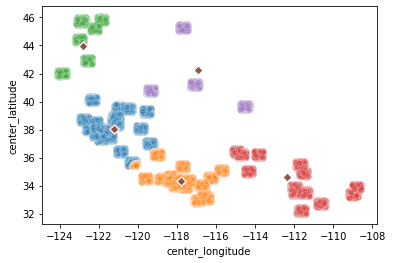

In [35]:
import seaborn as sns
markers ={"clusters" : "x"}
for i in range(5):
    mask = df.prediction == i
    sns.scatterplot(df.original_longitude[mask], df.original_latitude[mask],alpha=0.2)
#cmap = sns.cubehelix_palette(dark=.6, light=.4, as_cmap=True)
ax = sns.scatterplot(x=df['center_longitude'], y=df['center_latitude'],palette="Set2", legend='full', marker="D",alpha=1)

## Synthetic

In [ ]:
bucket="s3://dsde6007.rahul/sample_geo.txt"

In [ ]:
data = sc.textFile(bucket)

In [ ]:
def clean_data(data):
  data = data.split("\n")
  data = data.split("\t")
  data[0] = data[0].astype(float)
  data[1] = data[1].astype(float)
  data[2] = data[2].astype(int)
  return data

In [0]:
data = clean_data(data)

In [37]:
data.cache()
data.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True)

]))

In [39]:
df.rdd.cache()
df.rdd.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [40]:
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X = vecAssembler.transform(df)

X.cache()
print(X.rdd.getStorageLevel())

# Models
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X)

predictions2 = model2.transform(X2)
predictions4 = model4.transform(X2)

predictions2.cache()
predictions4.cache()

# Results
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()
print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))
timetable.append((time.time() - start_time))

Serialized 1x Replicated
Cluster Centers K=2: 
[ 37.56474721 -82.55711082]
[  38.07161548 -116.43342043]
Cluster Centers K=4: 
[ 40.14836238 -76.96598964]
[  35.57495006 -113.07189577]
[  41.49405837 -121.33793417]
[ 35.11449777 -87.93102449]
--- 5.702360153198242 seconds ---


In [0]:
rdd_predictions2 = predictions2.rdd.map(lambda x: (x[0],x[1],x[3],float(centers2[x[3]][0]),float(centers2[x[3]][1])))
df = spark.createDataFrame(rdd_predictions2, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [0]:
df = df.withColumn("gsc_dist", (\
                        geodesic(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude"))))\
        .withColumn("eu_dist", distance.euclidean(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude")))

In [44]:
df.rdd.cache()

MapPartitionsRDD[288] at javaToPython at NativeMethodAccessorImpl.java:0

In [0]:
df = df.select("*").toPandas()

In [47]:
df.head()

,original_latitude,original_longitude,prediction,center_latitude,center_longitude,gc_dist,eu_dist
0,37.772541,-77.499550,0,37.564747,-82.557114,445697.465339,25.622130
1,42.090134,-87.689156,0,37.564747,-82.557114,667018.426802,46.816980
2,39.563419,-75.587532,0,37.564747,-82.557114,645216.022961,52.569759
3,39.453022,-87.693741,0,37.564747,-82.557114,493701.579213,29.950522
4,38.953800,-77.016563,0,37.564747,-82.557114,507715.219519,32.627166


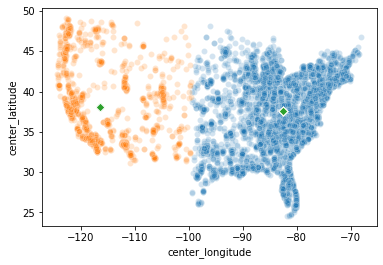

In [50]:
import seaborn as sns
markers ={"clusters" : "x"}
for i in range(2):
    mask = df.prediction == i
    sns.scatterplot(df.original_longitude[mask], df.original_latitude[mask], alpha=0.2)
#cmap = sns.cubehelix_palette(dark=.6, light=.4, as_cmap=True)
ax = sns.scatterplot(x=df['center_longitude'], y=df['center_latitude'],palette="Set2", legend='full', marker="D",alpha=1)

In [0]:
rdd_predictions4 = predictions4.rdd.map(lambda x: (x[0],x[1],x[3],float(centers4[x[3]][0]),float(centers4[x[3]][1])))
df = spark.createDataFrame(rdd_predictions4, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [0]:
df = df.withColumn("gsc_dist", (\
                        geodesic(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude"))))\
        .withColumn("eu_dist", distance.euclidean(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude")))

In [53]:
df.rdd.cache()

MapPartitionsRDD[318] at javaToPython at NativeMethodAccessorImpl.java:0

In [0]:
df = df.select("*").toPandas()

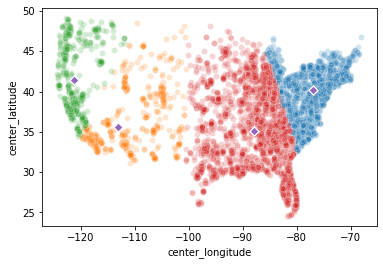

In [57]:
import seaborn as sns
markers ={"clusters" : "x"}
for i in range(4):
    mask = pandas_df.prediction == i
    sns.scatterplot(df.original_longitude[mask], df.original_latitude[mask],alpha=0.2)
#cmap = sns.cubehelix_palette(dark=.6, light=.4, as_cmap=True)
ax = sns.scatterplot(x=df['center_longitude'], y=df['center_latitude'],palette="Set2", legend='full', marker="D",alpha=1)

## DBPedia

In [ ]:
bucket="s3://dsde6007.rahul/lat_longs.txt"

In [ ]:
data = sc.textFile(bucket)

In [0]:
import re
def clean_data(data):
  data = data.split(" ")
  data[0] = re.sub("[^\d.-]+[.]{1}[^\d.]+", "delete", data[0])
  data = (data[0], data[1], data[2])

In [ ]:
data = clean_data(data)

In [59]:
data.cache()
data.getStorageLevel()

StorageLevel(False, True, False, False, 1)

In [0]:
from pyspark.sql import types
df = spark.createDataFrame(data, schema=types.StructType([\
                                                        types.StructField('latitude', types.FloatType(),True),
                                                        types.StructField('longitude', types.FloatType(),True),
                                                        types.StructField('Site', types.StringType(),True)

]))

In [61]:
df.show(5)

+---------+---------+--------------------+
| latitude|longitude|                Site|
+---------+---------+--------------------+
|     36.7|3.2166667|<http://dbpedia.o...|
|     42.5|1.5166667|<http://dbpedia.o...|
|12.516666|-70.03333|<http://dbpedia.o...|
|-8.833333|13.333333|<http://dbpedia.o...|
|41.333332|     19.8|<http://dbpedia.o...|
+---------+---------+--------------------+
only showing top 5 rows



In [62]:
df.rdd.cache()

MapPartitionsRDD[343] at javaToPython at NativeMethodAccessorImpl.java:0

In [63]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import time
start_time = time.time()

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
X = vecAssembler.transform(df)

X.rdd.cache()

# Models
kmeans2 = KMeans().setK(2).setSeed(1)
model2 = kmeans2.fit(X)

kmeans4 = KMeans().setK(4).setSeed(1)
model4 = kmeans4.fit(X)

kmeans6 = KMeans().setK(6).setSeed(1)
model6 = kmeans6.fit(X)

predictions2 = model2.transform(X)
predictions4 = model4.transform(X)
predictions6 = model6.transform(X)

predictions2.rdd.cache()
predictions4.rdd.cache()
predictions6.rdd.cache()

# Results
centers2 = model2.clusterCenters()
centers4 = model4.clusterCenters()
centers6 = model6.clusterCenters()
print("Cluster Centers K=2: ")
for center in centers2:
    print(center)
print("Cluster Centers K=4: ")
for center in centers4:
    print(center)
print("Cluster Centers K=6: ")
for center in centers4:
    print(center)
print("--- %s seconds ---" % (time.time() - start_time))
timetable.append((time.time() - start_time))

Cluster Centers K=2: 
[40.18205687 32.48327172]
[ 35.94167287 -88.83209608]
Cluster Centers K=4: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]
Cluster Centers K=6: 
[48.43652453  9.99936844]
[ 35.93470852 -88.9150858 ]
[ 18.51080852 123.643959  ]
[28.35921384 56.72666129]
--- 35.24681353569031 seconds ---


In [0]:
rdd_predictions4 = predictions4.rdd.map(lambda x: (x[0],x[1],x[4],float(centers4[x[4]][0]),float(centers4[x[4]][1])))
df = spark.createDataFrame(rdd_predictions4, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [ ]:
df = df.withColumn("gsc_dist", (\
                        geodesic(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude"))))\
        .withColumn("eu_dist", distance.euclidean(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude")))

In [0]:
df = df.select("*").toPandas()

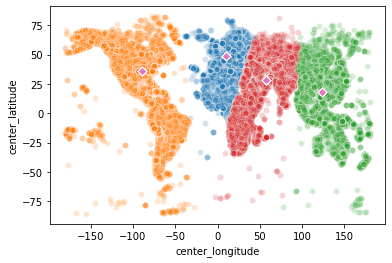

In [67]:
import seaborn as sns
markers ={"clusters" : "x"}
for i in range(6):
    mask = df.prediction == i
    sns.scatterplot(df.original_longitude[mask], df.original_latitude[mask], alpha=0.2)
#cmap = sns.cubehelix_palette(dark=.6, light=.4, as_cmap=True)
ax = sns.scatterplot(x=df['center_longitude'], y=df['center_latitude'],palette="Set2", legend='full', marker="D",alpha=1)

In [0]:
rdd_predictions6 = predictions6.rdd.map(lambda x: (x[0],x[1],x[4],float(centers6[x[4]][0]),float(centers6[x[4]][1])))
df = spark.createDataFrame(rdd_predictions6, schema=types.StructType([\
                                                        types.StructField('original_latitude', types.FloatType(),True),
                                                        types.StructField('original_longitude', types.FloatType(),True),
                                                        types.StructField('prediction', types.IntegerType(),True),
                                                        types.StructField('center_latitude', types.FloatType(),True),
                                                        types.StructField('center_longitude', types.FloatType(),True)
]))

In [ ]:
df = df.withColumn("gsc_dist", (\
                        geodesic(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude"))))\
        .withColumn("eu_dist", distance.euclidean(F.col("center_latitude"), F.col("center_longitude"), \
                         F.col("original_latitude"), F.col("original_longitude")))

In [0]:
df = df.select("*").toPandas()

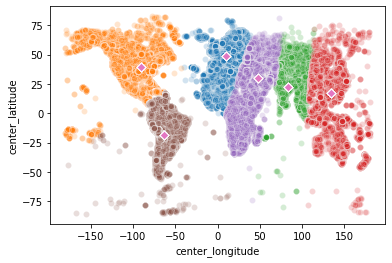

In [71]:
import seaborn as sns
markers ={"clusters" : "x"}
for i in range(6):
    mask = df.prediction == i
    sns.scatterplot(df.original_longitude[mask], df.original_latitude[mask], palette="Set2", alpha=0.2)
#cmap = sns.cubehelix_palette(dark=.6, light=.4, as_cmap=True)
ax = sns.scatterplot(x=df['center_longitude'], y=df['center_latitude'],palette="black",marker="D",alpha=1)

In [72]:
timetable

[15.227659940719604, 5.702495574951172, 35.24689960479736]